In [1]:
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import seaborn as sns

In [2]:
raw_df = pd.read_csv("2024_us_movie_ids.csv")
api_key = "c21328225264fd8b288c52d1ddfbca43"
base_url = 'https://api.themoviedb.org/3/movie/'
movie_ids = raw_df["movie_id"].astype(int).tolist()

In [3]:
def fetch_and_categorize_movies(movie_id_list, api_key, base_url):
    """
    Fetches details (runtime, rating) for a list of movie IDs,
    and returns a DataFrame with a 'budget_category' column.
    """
    movie_data = []
    total_ids = len(movie_id_list)

    # loops through movie ids in the list
    for i, movie_id in enumerate(movie_id_list):
        url = f"{base_url}{movie_id}" # creates new url for each movie id
        params = {'api_key': api_key, 'language': 'en-US'} # using api key and in english
        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            # add id, title, runtime, and rating of the movie
            movie_data.append({
                'id': movie_id,
                'title': data.get('title'),  
                'runtime': data.get('runtime', 0),
                'rating': data.get('vote_average')
            })
            time.sleep(0.5)
        # if it fails, raise error
        except requests.exceptions.RequestException as e:
            print(f"Error fetching details for ID {movie_id}: {e}. Setting runtime/rating to 0.")
            # default entry to 0 if there is an error
            movie_data.append({'id': movie_id, 'runtime': 0, 'rating': 0})
            time.sleep(0.5)
           
    # output result in pandas dataframe
    df = pd.DataFrame(movie_data)
    return df

In [4]:
#df = fetch_and_categorize_movies(movie_ids, api_key, base_url)

In [5]:
#df.to_csv("2024_movie_runtime_and_ratings", index = False)

In [6]:
runtime_ratings_data_df= pd.read_csv("2024_movie_runtime_and_ratings.csv")

In [7]:
runtime_ratings_data_df.head(5)

,id,title,runtime,rating
0,1097549,Babygirl,115,5.728
1,661539,A Complete Unknown,140,7.105
2,426063,Nosferatu,133,6.691
3,549509,The Brutalist,215,6.967
4,939243,Sonic the Hedgehog 3,110,7.642


Now we want to answer the question of whether runtime has an effect on movie rating or not.

Hypothesis:

$H_0:$ (Null hypothesis) Runtime does not affect movie rating

$H_a:$ (Alternative hypothesis) Runtime is associated with movie rating

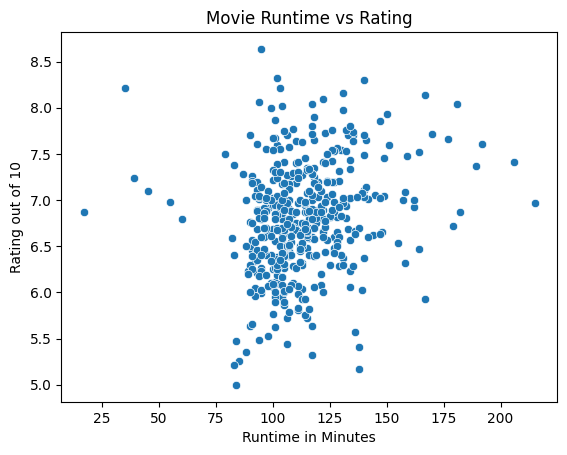

In [8]:
scatter_plot = sns.scatterplot(data=runtime_ratings_data_df, x="runtime", y="rating")
scatter_plot.set_xlabel("Runtime in Minutes")
scatter_plot.set_ylabel("Rating out of 10")
scatter_plot.set_title("Movie Runtime vs Rating")

plt.savefig("runtime_vs_rating.png", dpi=300, bbox_inches="tight")

We can observe some outliers from the scatterplot. For example, there are only a few runtimes that are less than 75 minutes and few above 150 minutes. Let's remove the outliers and look at the scatterplot again.

In [9]:
def remove_outliers(x, data):
    '''
    Removes outliers that lie outside of Q1-1.5*IQR and Q3+1.5*IQR
    '''
    Q1 = data[x].quantile(0.25)
    Q3 = data[x].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    clean_data = data[
        (data[x] >= lower_bound) &
        (data[x] <= upper_bound)]
    return clean_data

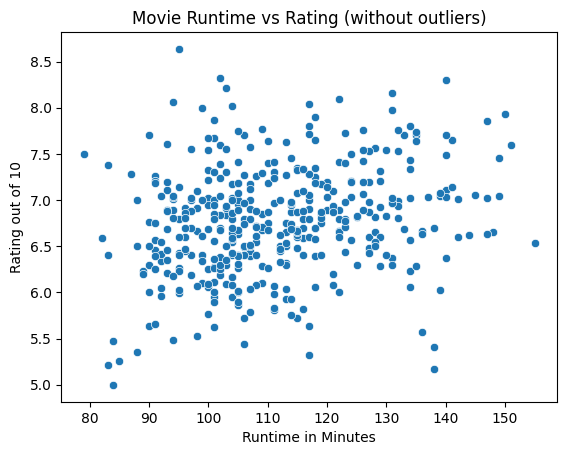

In [10]:
# use function to remove outliers
clean_runtime_ratings_data_df = remove_outliers("runtime", runtime_ratings_data_df)

# new scatterplot without outliers
scatter_plot_clean = sns.scatterplot(data=clean_runtime_ratings_data_df, x="runtime", y="rating")
scatter_plot_clean.set_xlabel("Runtime in Minutes")
scatter_plot_clean.set_ylabel("Rating out of 10")
scatter_plot_clean.set_title("Movie Runtime vs Rating (without outliers)")

plt.savefig("runtime_vs_rating_(without outliers).png", dpi=300, bbox_inches="tight")

There appears to be no obvious pattern or correlation between runtime and minutes, but let's check other diagnostics first.

In [11]:
clean_runtime_ratings_data_df[["rating", "runtime"]].describe()

,rating,runtime
count,416.000000,416.000000
mean,6.771413,111.579327
std,0.590320,15.044943
min,4.998000,79.000000
25%,6.400000,101.000000
50%,6.770000,109.000000
75%,7.144250,122.000000
max,8.637000,155.000000


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<function matplotlib.pyplot.show(close=None, block=None)>

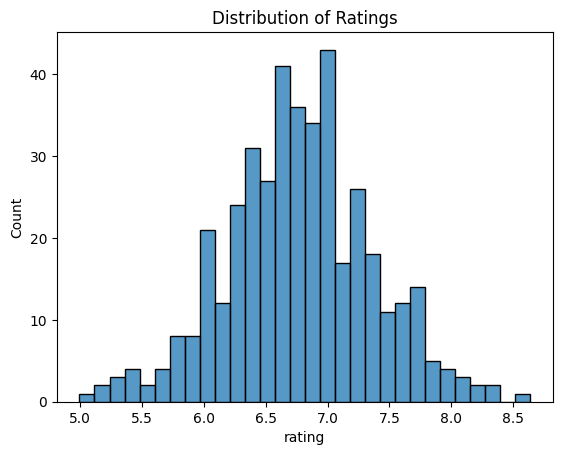

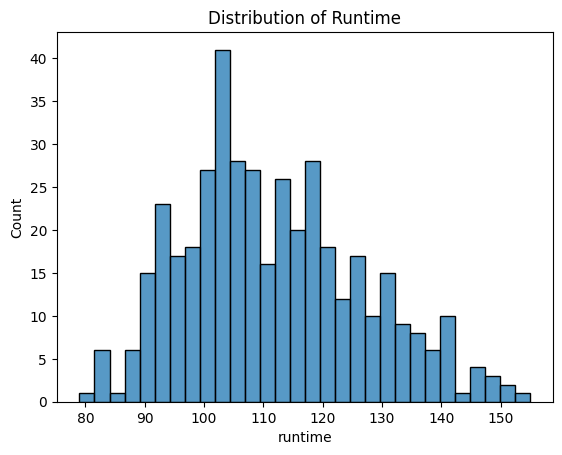

In [12]:
#Histogram Distributions
# histogram for distribution of ratings
plt.figure()
sns.histplot(clean_runtime_ratings_data_df["rating"], bins=30)
plt.title("Distribution of Ratings")
plt.savefig("distribution_of_ratings.png", dpi=300, bbox_inches="tight")

# histogram for distribution of runtimes
plt.figure()
sns.histplot(clean_runtime_ratings_data_df["runtime"], bins=30)
plt.title("Distribution of Runtime")

plt.savefig("distribution_of_runtime.png", dpi=300, bbox_inches="tight")

plt.show

Both the ratings and the runtime appear to be normally distributed. There are no obvious gaps or clusters in the histograms. Runtime may be slightly skewed right, but this is not significant enough to rule out the possibility of a linear model. Let's now plot residuals versus the fitted values to see whether a linear model meets the assumptions of linearity and constant variance.

In [ ]:
def regression(x, y, data, silent = False):
    '''
    Performs regression using statsmodels library and returns the model. Can print summary results if desired
    
    LEVERAGED LLM FOR COMPONENTS OF THIS CODE.
    '''
    X = data[x]
    y = data[y]
    X = sm.add_constant(X) # to not go through (0,0)
    model = sm.OLS(y, X).fit()

    # don't print the summary of the  model if silent
    if silent:
        return model
    else:
        print((model.summary()))
    return model

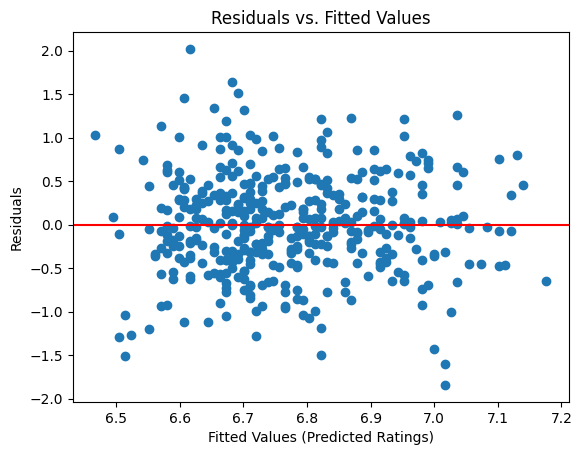

In [ ]:
# LEVERAGED LLM FOR COMPONENTS OF THIS CODE.

runtime_linear_model = regression("runtime","rating", clean_runtime_ratings_data_df, silent = True)

plt.scatter(runtime_linear_model.fittedvalues, runtime_linear_model.resid)
plt.axhline(0, color='red')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values (Predicted Ratings)")
plt.ylabel("Residuals")

plt.savefig("Residuals vs. Fitted Values.png", dpi=300, bbox_inches="tight")

From this residual plot, the residuals appear to be randomly scattered around 0 with no clear pattern, indicating the linearity assumption is met. The spread of the residuals also appears to be random, meaning the constant variance assumption is also met. We will proceed with using a linear model. However, it should be noted that the spread of residual values is large, given that our ratings are only out of 10 and we get residuals ranging from -2 to 2.

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     24.77
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           9.47e-07
Time:                        00:43:46   Log-Likelihood:                -358.42
No. Observations:                 416   AIC:                             720.8
Df Residuals:                     414   BIC:                             728.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7311      0.211     27.175      0.0

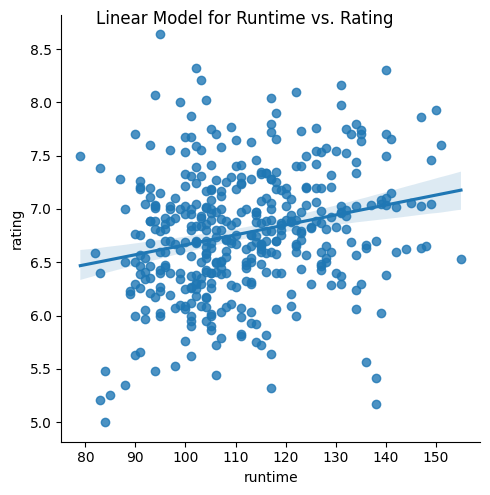

In [15]:
# create plot based on linear model
plot1 = sns.lmplot(data=clean_runtime_ratings_data_df, x="runtime", y="rating")
plot1.fig.suptitle("Linear Model for Runtime vs. Rating")
plot1.fig.savefig("linear_runtime_vs_rating.png", dpi=300, bbox_inches="tight")

# print results of linear model
print(runtime_linear_model.summary())

After fitting a linear regression model, runtime was found to be significant, with a p-value of less than 0.001. This indicates we should reject the null hypothesis and conclude that runtime does have a significant effect on a movies' rating. On average, for every additional minute of runtime, the predicted movie rating increase is about 0.0093. However, an $R^2 = 0.056$ means that runtime only accounts for $5.6\%$ of the variation in ratings. This means runtime is a weak predictor of movie rating. Likely other factors, such as budget or cast, for example, may account for majority of rating variation. Let's try not using a linear regression to see if we can improve our results.

/tmp/ipykernel_2016/227391630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_runtime_ratings_data_df["runtime_sq"] = clean_runtime_ratings_data_df["runtime"] ** 2


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     12.55
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           5.11e-06
Time:                        00:43:47   Log-Likelihood:                -358.24
No. Observations:                 416   AIC:                             722.5
Df Residuals:                     413   BIC:                             734.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9084      1.376      3.567      0.0

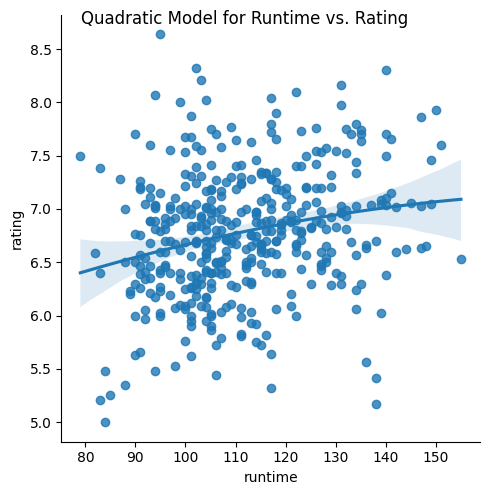

In [16]:
# running a quadratic model by adding a squared term
clean_runtime_ratings_data_df["runtime_sq"] = clean_runtime_ratings_data_df["runtime"] ** 2

runtime_quadratic_model = regression(["runtime","runtime_sq"],"rating", clean_runtime_ratings_data_df, silent = False)

# using order 2 will give us a quadratic regression
plot2 = sns.lmplot(data=clean_runtime_ratings_data_df, x="runtime", y="rating", order=2)
plot2.fig.suptitle("Quadratic Model for Runtime vs. Rating")
plot2.fig.savefig("quadratic_runtime_vs_rating.png", dpi=300, bbox_inches="tight")


To test whether the relationship between runtime and rating was nonlinear, we fit a quadratic regression model. However, this model showed that neither the runtime nor runtime$^2$  term were significant ($p$-values of $0.323$ and $0.545$, respectively). Additionally, the $R^2$ only increased by $0.1\%$. This suggests that a quadratic model is no better than a linear model.

This analysis shows that a movies' runtime has a statistically significant effect on its rating, but practically, the effect is almost negligible. After removing outliers, our linear model showed a positive association between runtime and rating, however, rating only explains a small proportion of overall variation (with $R^2 \approx 0.056$). We then tested a quadratic model to see if nonlinear models have potential, but neither runtime nor the squared term were significant (both had $p$ values $>0.1$). These results suggest that runtime alone is not a good predictor of movie ratings and there are likely other factors that better predict a movie's ratings.

# Budget vs. Runtime #
Let's take the budget dataset and join it with our current runtime dataset

Now we want to answer the question of whether budget has an effect on runtime.

Hypothesis:

$H_0:$ (Null hypothesis) Budget does not affect movie runtime

$H_a:$ (Alternative hypothesis) Budget is associated with movie runtime

In [17]:
runtime_df = clean_runtime_ratings_data_df
budget_df = pd.read_csv("2024_movie_budget_dataset.csv")

In [18]:
print(budget_df.columns)

Index(['id', 'title', 'budget', 'revenue', 'rating', 'budget_category'], dtype='object')


In [19]:
print(runtime_df.columns)

Index(['id', 'title', 'runtime', 'rating', 'runtime_sq'], dtype='object')


In [20]:
budget_runtime_df = pd.merge(runtime_df, budget_df, on="id", how="inner")

In [21]:
budget_runtime_df.head() #we observe duplicate columns so let's clean the dataframe

,id,title_x,runtime,rating_x,runtime_sq,title_y,budget,revenue,rating_y,budget_category
0,1097549,Babygirl,115,5.728,13225,Babygirl,20000000,60934894,5.728,Low Budget
1,661539,A Complete Unknown,140,7.105,19600,A Complete Unknown,65000000,138003641,7.104,High Budget
2,426063,Nosferatu,133,6.691,17689,Nosferatu,50000000,181764515,6.691,High Budget
3,939243,Sonic the Hedgehog 3,110,7.642,12100,Sonic the Hedgehog 3,122000000,492162604,7.642,High Budget
4,929204,Wallace & Gromit: Vengeance Most Fowl,79,7.500,6241,Wallace & Gromit: Vengeance Most Fowl,0,191452,7.500,Low Budget


In [22]:
budget_runtime_df = budget_runtime_df[[
    "id",
    "title_x",
    "runtime",
    "budget",
    "budget_category"]]
budget_runtime_df = budget_runtime_df.rename(columns={"title_x": "title"}) # rename column to just title

In [23]:
budget_runtime_df.head()

,id,title,runtime,budget,budget_category
0,1097549,Babygirl,115,20000000,Low Budget
1,661539,A Complete Unknown,140,65000000,High Budget
2,426063,Nosferatu,133,50000000,High Budget
3,939243,Sonic the Hedgehog 3,110,122000000,High Budget
4,929204,Wallace & Gromit: Vengeance Most Fowl,79,0,Low Budget


In [24]:
budget_runtime_df[["budget", "runtime"]].describe()

,budget,runtime
count,4.160000e+02,416.000000
mean,4.589554e+07,111.579327
std,6.768144e+07,15.044943
min,0.000000e+00,79.000000
25%,0.000000e+00,101.000000
50%,2.000000e+07,109.000000
75%,7.000000e+07,122.000000
max,5.839000e+08,155.000000


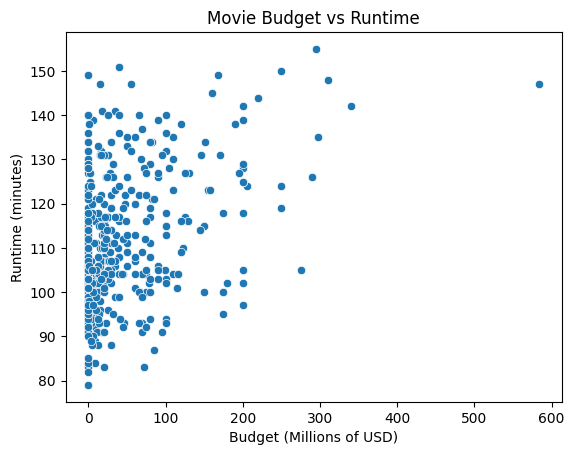

In [25]:
budget_runtime_df["budget_millions"] = budget_runtime_df["budget"] / 1_000_000 # to make it easier to read budget

scatter_plot = sns.scatterplot(data=budget_runtime_df, x="budget_millions", y="runtime")
scatter_plot.set_xlabel("Budget (Millions of USD)")
scatter_plot.set_ylabel("Runtime (minutes)")
scatter_plot.set_title("Movie Budget vs Runtime")
plt.savefig("Movie Budget vs Runtime.png", dpi=300, bbox_inches="tight")

We observe there is a few outliers, so let's remove those before looking at the distributions for budget (we've already looked at the distribution for runtime). 

In [26]:
# use our remove outlier function from earlier
clean_budget_runtime_df = remove_outliers("budget", budget_runtime_df)

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


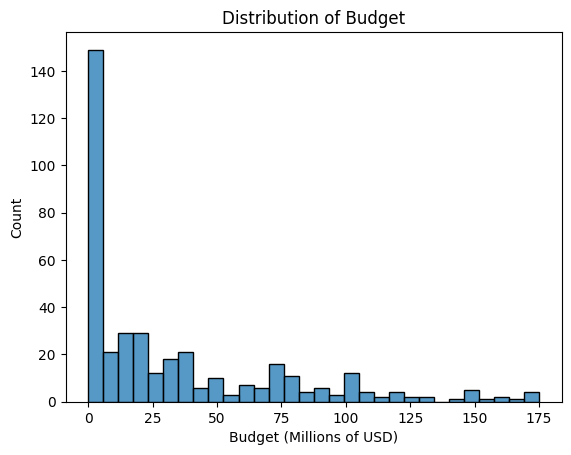

<Figure size 640x480 with 0 Axes>

In [27]:
sns.histplot(clean_budget_runtime_df["budget_millions"], bins=30)
plt.xlabel("Budget (Millions of USD)")
plt.title("Distribution of Budget")
plt.show()
plt.savefig("distribution_of_budget.png", dpi=300, bbox_inches="tight")


# We've already seen the runtime distribution
# sns.histplot(clean_df["runtime"], bins=30)
# plt.title("Runtime Distribution")
# plt.show()


We observe that budget is heavily skewed right. This degree of skew suggests that we should compute $log(\text{budget})$ in order to stabilize variance, normalize residuals, and improve our overall model.

In [28]:
# only keep the movies with budgets greater than 0 (so we can take log without problems)
clean_budget_runtime_df = clean_budget_runtime_df[clean_budget_runtime_df["budget"] > 0]
clean_budget_runtime_df["log_budget"] = np.log(clean_budget_runtime_df["budget"])

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


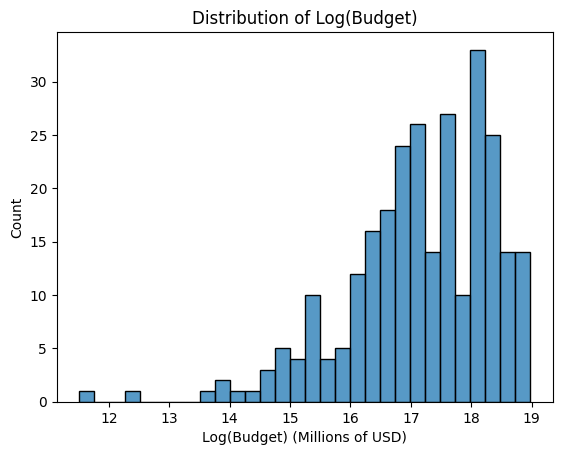

<Figure size 640x480 with 0 Axes>

In [29]:
sns.histplot(clean_budget_runtime_df["log_budget"], bins=30)
plt.xlabel("Log(Budget) (Millions of USD)")
plt.title("Distribution of Log(Budget)")
plt.show()
plt.savefig("distribution_of_log(budget).png", dpi=300, bbox_inches="tight")


After taking the log(budget), our distribution is much more symmetrical and more suitable for linear regression. Let's run our model using log(budget) and observe the results.

                            OLS Regression Results                            
Dep. Variable:                runtime   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     25.39
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           8.60e-07
Time:                        00:43:57   Log-Likelihood:                -1100.1
No. Observations:                 271   AIC:                             2204.
Df Residuals:                     269   BIC:                             2211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6861     12.151      4.171      0.0

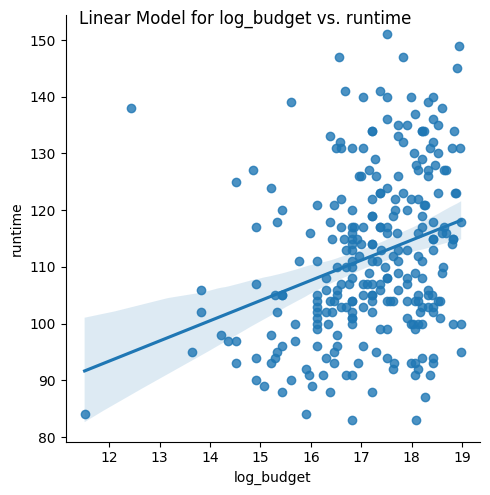

In [30]:
budget_runtime_linear_model = regression("log_budget", "runtime", clean_budget_runtime_df, silent = False)


plot3 = sns.lmplot(data=clean_budget_runtime_df, x="log_budget", y="runtime")
plot3.fig.suptitle("Linear Model for log_budget vs. runtime")
plot3.fig.savefig("linear_log(budget)_vs_runtime.png", dpi=300, bbox_inches="tight")



We see from our results that for every increase in log(budget), the movie's runtime is expected to increase by about 3.56 minutes on average. The log_budget p-value is < 0.001, meaning that there is strong evidence that higher-budget movies tend to be longer. However, only 8.6% of the runtime variation is explained by the budget. Similar to our results from runtime and ratings, budget is a statistically significant factor, but not a strong predictor for a movie's runtime.